# Interval Basis with graded Smith Normal Form

We have a family of maps of $\mathbb{F}$-vector spaces $\mathcal{M} = (M_i , \varphi_i)_i$

Fix the standard grading on $\mathbb{F[x]}$. Build a graded $\mathbb{F[x]}$-module $\alpha(\mathcal{M}) := \bigoplus_i M_i$, with this given grading, i.e. such that $x^pM_i \subseteq M_{i+p}$. In particular, we define that $x$ acts on a homogenous element $m_i$ by $\varphi_i(m_i)$.  

In other words, if we fix the obvious basis for $\bigoplus_i M_i$, we can write the $\varphi_i$'s together as a map $\Phi : \bigoplus_i M_i \rightarrow \bigoplus_i M_i$. So, on any element $m \in \alpha(\mathcal{M})$, multiplication by polynomial $p(x) \in \mathbb{F}(x)$ acts as $p(x) \cdot m = p(\Phi)(m)$. 

$\alpha(\mathcal{M})$ must fit in the following exact sequence  
$\ker\mu \ \overset{i}{\hookrightarrow} \mathbb{F}[x]^g \  \overset{\mu}{\twoheadrightarrow} \ \alpha(\mathcal{M})$  
which amounts to giving a *presentation* of $\alpha(\mathcal{M})$.

Fixing $g$ generators of the free module, saying the module is *given* amounts to giving homogenous generators of the syzygy module, i.e. a set of homogenous elements of the free module that span Im $i$. Then $\alpha(\mathcal{M}) \cong \mathbb{F}[x]^g \ / \ \text{Im } i \cong \mathbb{F}[x]^g \ / \ \ker \mu$.

As per [Corbet, Kerber](https://d-nb.info/1166945936/34), from the $\varphi_i$'s one can build these *homogenous* generators of Im $i$, $\langle r_1 , \dots , r_s \rangle$. They can be stored as a $g \ \times \ s$ matrix $S$ representing map $i$. 
It then holds  
$\alpha(\mathcal{M}) \cong \mathbb{F}[x]^g \ / \ \text{Im }S \cong \mathbb{F}[x]^g \ / \ \langle r_1, \dots r_s \rangle$   
In particular, by the procedure in the paper one obtains a matrix $S$ with the same size as $\Phi$, i.e. where $g = s = \dim \bigoplus_i M_i$.  
In general, this presentation is far from minimal, in the sense that several pairs of generator-relation can be discarded while maintaining the module fixed.

The graded Smith Normal Form in [Skraba, Vejdemo-Johansson](https://arxiv.org/pdf/1302.2015.pdf) computes a *graded* primary decomposition over $\mathbb{F}[x]$ of this module, changing basis for generators and syzygies to obtain new (homogenous) relations $r'_1 , \dots , r'_{g}$ that are,  up to reordering, diagonal. Of these, some are zero, corresponding to free generators of the module. Others are units (invertible in $\mathbb{F}[x]$, i.e. non-zero scalars), which correspond to surplus generators which should be discarded. Finally others are elements of positive degree, corresponding to torsion elements. Then    
$\alpha(\mathcal{M}) \cong \mathbb{F}[x]^g \ / \ \left( \langle r'_1 \rangle \oplus \dots \oplus \langle r'_g\rangle \right) \ \overset{?}{\cong} \ \mathbb{F}[x] \ / \ \langle r'_1\rangle \oplus \dots \oplus \mathbb{F}[x] \ / \ \langle r'_g\rangle \ \cong \ \mathbb{F}[x]^d \oplus \bigoplus_{\deg r'_i > 0} \mathbb{F}[x] \ / \ \langle r'_i\rangle \left( \oplus \bigoplus_{r'_j \text{ unit}} 0 \right)$ 

Additionally, I think we can modify the gSNF to work on scalars in $\mathbb{F}$ instead of polynomials, keeping track of degree by knowing the degree of relations and generators.

In [151]:
import numpy as np

## Generate a random module

Choose dimensions

In [376]:
dims = [2,1,4,4,1]

Generate random matrices

In [377]:
Ms = [ np.random.rand(dims[i+1],dims[i]) for i in range(len(dims)-1) ]
Ms.append( np.zeros((1,dims[-1])))

In [378]:
Ms

[array([[0.27, 0.17]]),
 array([[0.16],
        [0.61],
        [0.60],
        [0.09]]),
 array([[0.85, 0.75, 0.09, 0.60],
        [0.97, 0.18, 0.43, 0.74],
        [0.65, 0.52, 0.49, 0.07],
        [0.80, 0.23, 0.71, 0.91]]),
 array([[0.89, 0.02, 0.27, 0.91]]),
 array([[0.00]])]

In [379]:
#Ms = [ np.ndarray((2,1),buffer=np.array([1,0])) ,np.ndarray((1,2),buffer=np.array([1,0])), \
      #np.ndarray((1,1),buffer = np.matrix([0])) ]
#Ms

Generate the big matricione $\Phi$ and the matrix of relations

In [380]:
BigDim = np.sum(dims)
Rel = np.zeros((BigDim, BigDim))
BigDim

12

In truth we don't need it.. Use it for the relations

## Relations

Keep track of the indices where each block (degree) ends and the following one begins.

In [381]:
blocks = [0]
for d in dims:
    blocks.append( blocks[-1] + d )

blocks

[0, 2, 3, 7, 11, 12]

Assume matrix is $m \ x \ n$. **Remember the minus**. Here we can force non-zero elements to be 1, so it reads a little better.

In [438]:
for i, mat in enumerate(Ms):
    # OPTIONAL for readability: uncomment to make all off-diagonal non-zero entries into ones
    #mat[ mat != 0 ] = 1
    (m,n) = mat.shape
    prevDegIndex = blocks[i]
    nextDegIndex = blocks[i+1]
    for cols in range(n):
        Rel[ prevDegIndex + cols , prevDegIndex + cols ] = -1 # set the "x" WITH A MINUS SIGN!
        Rel[ nextDegIndex : nextDegIndex + m , prevDegIndex + cols ] = mat[:, cols] # set its image

In [437]:
#Rel[2,0]=0
#Rel

## Graded Smith Normal Form
But without polynomials

Steps:  
All columns are marked as non-processed. While there are unprocessed columns:
 - For the left-most unprocessed column c, find the low l
 - From row l-1 upward, get zero in column c
 - From column c+1 rightward, get zero in row l
 - Mark column c (and row l?) as processed

#### Find degree of generators, stored in a vector

In [384]:
genDegs = []
for i,d in enumerate(dims):
    genDegs.extend( [i]*d )
    
genDegs

[0, 0, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4]

#### Find degree of relations
A relation *in our case* comes from $\varphi_{i,i+1}$, so its degree is $i+1$. So we can just increase the degree of generators by 1

In [385]:
relDegs = [i+1  for i in genDegs]
relDegs

[1, 1, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5]

In [386]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

For each column, count how many blocks have non-zero elements, as the reduction progresses

In [413]:
def entriesPerCol(Mat):
    
    nonzero = np.count_nonzero(Mat, axis = 0)
    print('# nonzero entries per column')
    print(nonzero)

def distrInBlocks(Mat):
    
    vals = np.zeros((Mat.shape[1]), dtype=int)
    
    for c in range(Mat.shape[1]):
        
        col = Mat[:,c]
        count = 0

        for i in range(len(blocks)-1):
            if any(col[blocks[i]: blocks[i+1]] != 0) :
                count += 1
                
        vals[c] = count
    print('# of blocks with nonzero entries')
    print(vals)

entriesPerCol(Rel)

# nonzero entries per column
[2 2 5 5 5 5 5 2 2 2 2 1]


In [414]:
def spyMatrix(Mat):
    
    M = Mat.copy()
    M[ M != 0 ] = 1
    
    ax = plt.gca()
    fig = ax.figure
    fig.set_size_inches(3.5,3.5)  # Set the figure size (width, height)

    ax.spines[:].set_visible(False)
    plt.grid(color='white', linestyle='-', linewidth=5.5)
    
    plt.xticks(np.arange(-0.5, M.shape[1], 1), [])
    plt.yticks(np.arange(-0.5, M.shape[0], 1), [])
    
    ax.set_yticks(np.array([x-0.5 for x in blocks]), minor=True)
    
    for x in blocks:
        ax.vlines(x=x - 0.5, ymin=-0.5, ymax=M.shape[0] - 0.5, colors="red", linewidth=.5, linestyle='-.')
        
    for y in blocks:
        ax.hlines(y=y - 0.5, xmin=-0.5, xmax=M.shape[0] - 0.5, colors="red", linewidth=.5, linestyle='-.')

    
    im = ax.imshow(M, cmap='Greys')
    plt.show()

#### Now the SNF reduction
In matrix R we must, at each step, **multiply** by an elementary row operation matrix, **not** just add into the matrix element by element.

In [415]:
def low(v):
    return np.max(np.nonzero(v))

In [423]:
def grSNF( M, Rf , postprocess = None):
    '''Perform the graded Smith normal form reduction as in Skraba, Vejdemo-Johansson (2013)
    
    INPUT:
    M: (numpy matrix) square numpy matrix representing relations. It is up to the user to make sure 
        this is formed as described in De Gregorio et al. (2021). No guarantees on the output are given 
        otherwise
        
    Rf: (numpy matrix) matrix of the same shape as M, used to represent the row basis change performed
        during reduction
        
    postprocess: (function handle) Optional. If specified, it has to be a function that takes matrix M
        as argument. It will be called at the end of each iteration of the main for-cycle, the one reducing
        each column. It can be useful to print the matrix as it is being reduced, to visualize the algorithm,
        to evaluate the computational complexity, etc. E.g. the functions distrInBlocks or spyMatrix defined 
        above are good examples. 
    
    '''
    m,n = M.shape
    for c in range(n): # for each column
        try: # find the low
            l = low( M[:,c] )
        except ValueError as e: # column is empty, continue cycling
            continue
        # fix pivot
        pivot = M[l,c]
        for j in range(l-1,-1,-1): # REDUCE COLUMN: from row l upwards
            if M[j,c]!=0: # Non-zero: reduce with row l
                factor = M[j,c]
                M[j,c:] = pivot*M[j,c:] - factor*M[l,c:]
                # MARK IT AS ROW OPERATION
                R = np.identity(m)
                R[j,j] *= pivot
                R[j,l] -= factor
                Rf = np.matmul(R,Rf)
                # zero out explicitly to avoid numerical error
                M[j,c] = 0 
        #print('Col done')
        #print(M)
        for h in range(c+1,n): #REDUCE ROW: from column c+1 rightward
            if M[l,h]!=0: #Non zero: reduce with column c BUT column c is entirely zero except for the pivot
                M[l,h] -= M[l,h]*M[l,c] # this must be zero, so directly
                M[l,h] = 0
        #print('Row done')
        #print(M)
        
        ## OPTIONAL: PRINT THINGS AS THEY PROGRESS
        
        if postprocess is not None:
            print('Iteration ',c+1)
            postprocess(M)
        
    return M,Rf

Original
[2 2 5 5 5 5 5 2 2 2 2 1]


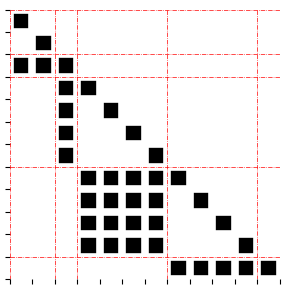

Iteration  1


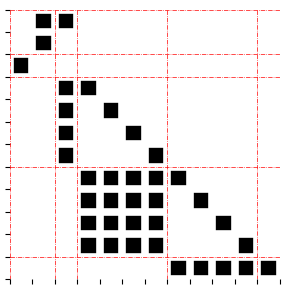

Iteration  2


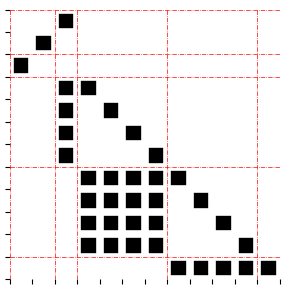

Iteration  3


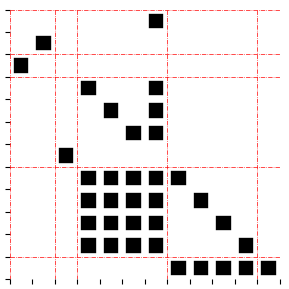

Iteration  4


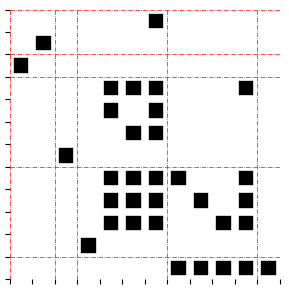

Iteration  5


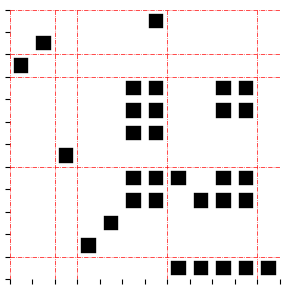

Iteration  6


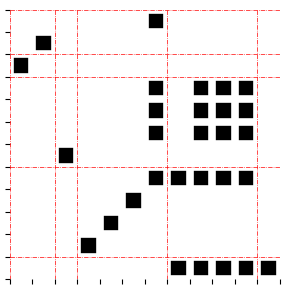

Iteration  7


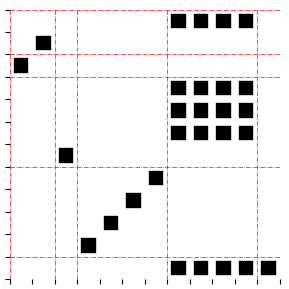

Iteration  8


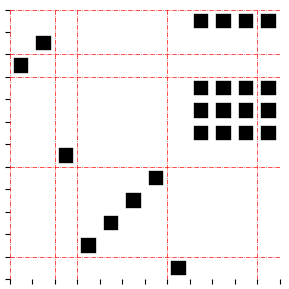

Iteration  9


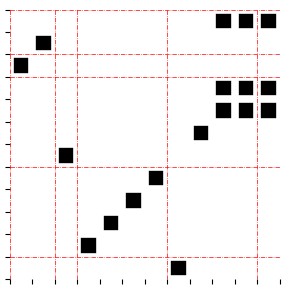

Iteration  10


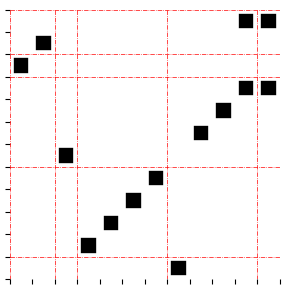

Iteration  11


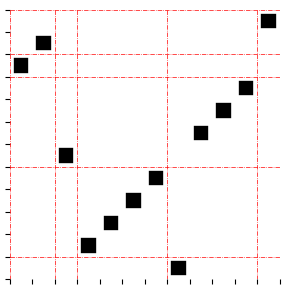

Iteration  12


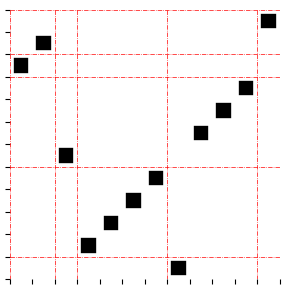

In [424]:
Rf = np.identity(BigDim) # init matrix for row change
#print(Rel)
#print('Non-zero elements in each column')
print('Original')
nonzero = np.count_nonzero(Rel, axis = 0)
print(nonzero)
spyMatrix(Rel)
plt.show()
SNF,Rf = grSNF(Rel.copy(),Rf, postprocess=spyMatrix)

Inverse of the basis change matrix. Each column $c$ represents the **new** generator $g'_c$ in terms of the **old** generators $g_1, \dots, g_g$. Those corresponding to a zero-length pair in SNF (an invertible element) can be discarded. The others, by the way, are an interval basis.

In [425]:
Interval= np.linalg.inv(np.matrix(Rf))
Interval

matrix([[364897811298339950629486592.00, -0.61, -3.68,
         1264541964608842.75, -363778777.20, -35348.07, -38.76, 1474.06,
         -0.00, 0.00, 0.00, -33.96],
        [0.00, 1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,
         0.00, 0.00],
        [0.00, 0.00, 1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,
         0.00, 0.00],
        [-0.00, -0.00, -0.00, -315092279288277.44, 101122049.19, 4137.44,
         1.72, -86.03, -9.95, 1.07, -1.26, 1.98],
        [-0.00, -0.00, -0.00, -0.00, -17362455.16, 3734.01, 6.40,
         -178.93, 2.67, -3.77, -0.00, 4.12],
        [0.00, 0.00, 0.00, 0.00, 0.00, 4675.64, 6.28, -284.94, 10.35,
         0.00, -0.00, 6.57],
        [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 1.00, 0.00, 0.00, 0.00,
         0.00, 0.00],
        [-0.00, -0.00, -0.00, -0.00, -0.00, -0.00, -0.00, -48.92, 5.54,
         1.90, 1.07, -0.00],
        [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 4.73, -0.37,
         1.21, 0.00],
        [0.00, 0.00, 0.00, 0.00, 0.

### Computing barcode, interval basis, and all.

In [426]:
barcode = []
persistences = []

for d in range(BigDim):
    try:
        killer = low(SNF[d,:])
        death = relDegs[killer]
    except ValueError as e:
        death = np.infty
    birth = genDegs[d]
    barcode.append( (birth, death) )
    persistences.append(  death - birth)
    
barcode

[(0, 5),
 (0, 1),
 (1, 1),
 (2, 4),
 (2, 4),
 (2, 4),
 (2, 2),
 (3, 3),
 (3, 3),
 (3, 3),
 (3, 3),
 (4, 4)]

#### Interval basis, just for the generators that matter

Columns show interval generators $G_i$ as combinations of old generators $g_j$. Green columns are *actual* generators, red ones are the discarded ones. Horizontal lines divide degrees.

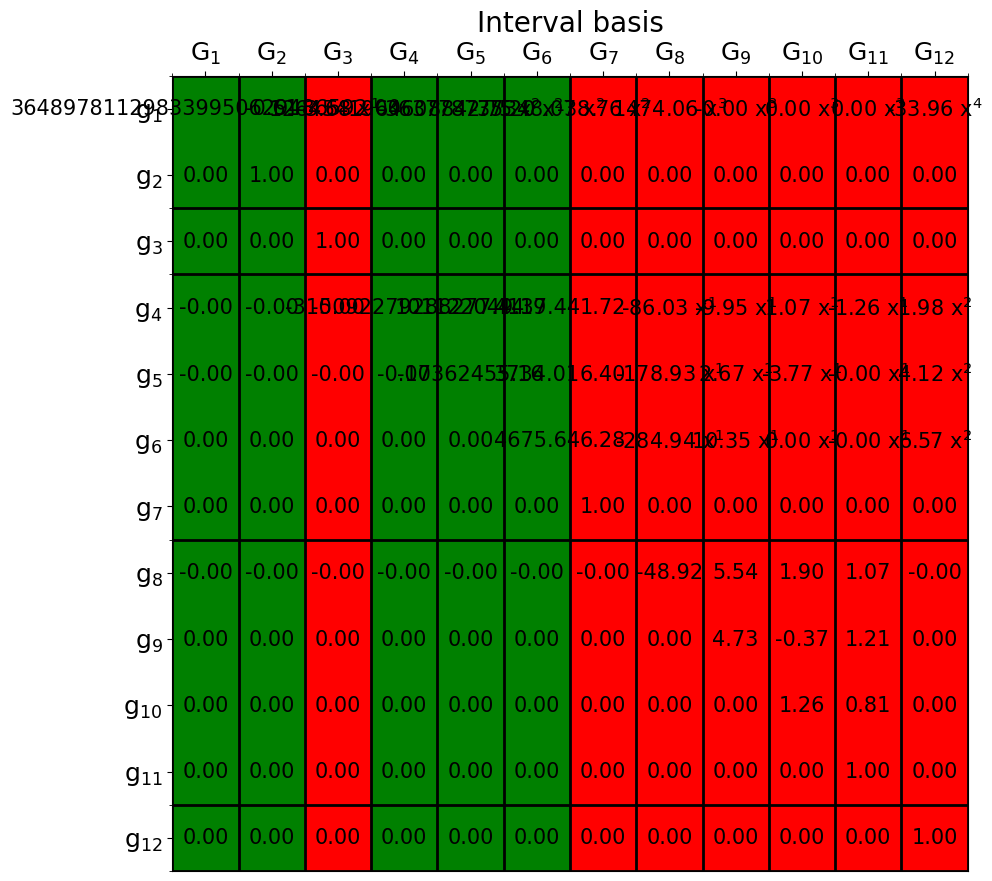

In [427]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors

intGens = [ f'G$_{{{i+1}}}$' for i in range(BigDim)]
oldGens = [ f'g$_{{{i+1}}}$' for i in range(BigDim)]

cmap = colors.ListedColormap(['green', 'red'])

bounds=[0,0.5,1]
norm = colors.BoundaryNorm(bounds, cmap.N)

keepOrDiscard = Rf.copy()
for c in range(BigDim):
    keepOrDiscard[:,c] = np.zeros((BigDim,)) if persistences[c]>0 else np.ones((BigDim,))

fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(keepOrDiscard,cmap=cmap,norm=norm,origin='upper')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(intGens)))
ax.set_xticklabels(intGens,size=18)
ax.set_yticks(np.arange(len(oldGens)))
ax.set_yticklabels(oldGens,size=18)

ax.set_xticks(np.arange(-.5, len(intGens), 1), minor=True)
ax.set_yticks(np.array([x-0.5 for x in blocks]), minor=True)

# Rotate the tick labels and set their alignment.
#plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
 #        rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(intGens)):
    for j in range(len(oldGens)):
        deg = genDegs[j]-genDegs[i]
        if deg == 0 or Interval[i,j]==0:
            term = ""
        else:
            term = f' x$^{{{deg}}}$'
        text = ax.text(j, i, f'{Interval[i, j]:1.2f}'+term,
                       ha="center", va="center", color="k", size=15)

ax.grid(which='minor',color='k', linestyle='-', linewidth=2)
ax.xaxis.tick_top()
ax.set_title("Interval basis",size=20)
fig.tight_layout()
plt.show()

### Examples

Let us take a (free) persistence module of chain complexes (over a field $\mathbb{F}$) $(C_\bullet)_i$ in a filtration. It then holds that all maps are injective, i.e. if we pick one generator for each simplex in the filtration the presentation has no relations.  
In other words, the module is just the direct sum of the steps.  
The maps,then, are simply the identity matrices of proper dimensions.  

Then, compute its simplicial homology over $\mathbb{F}$. We get a persistence module, not free in  general.

Make it  
$ 0 \rightarrow 0 \rightarrow \mathbb{R}^3$ 

$ 0 \rightarrow \mathbb{R} \rightarrow \mathbb{R}^3$ with $\partial_1 = \begin{pmatrix} -1 \\ 1 \\ 0 \end{pmatrix} $

$ 0 \rightarrow \mathbb{R}^3 \rightarrow \mathbb{R}^3$ with $\partial_1 = \begin{pmatrix} -1 & 0 & -1\\ 1 & -1 & 0 \\ 0 & 1 & 1 \end{pmatrix} $

$ \mathbb{R} \rightarrow \mathbb{R}^3 \rightarrow \mathbb{R}^3$ with $\partial_1 = \begin{pmatrix} -1 & 0 & -1\\ 1 & -1 & 0 \\ 0 & 1 & 1 \end{pmatrix} $ and $\partial_2 = \begin{pmatrix} 1 \\ 1 \\ -1 \end{pmatrix} $

In [428]:
Red , R = grSNF( np.matrix( [[1],[1],[-1]] ) , np.identity(3) )

In [429]:
Red

matrix([[ 0],
        [ 0],
        [-1]])

In [430]:
R

array([[-1.00, 0.00, -1.00],
       [0.00, -1.00, -1.00],
       [0.00, 0.00, 1.00]])

In [431]:
Red , R = grSNF( np.matrix( [[-1,0,-1],[1,-1,0],[0,1,1]] ) , np.identity(3) )

In [432]:
Red

matrix([[0, 0, 0],
        [1, 0, 0],
        [0, 1, 0]])

In [433]:
np.matrix( [[-1,0,-1],[1,-1,0],[0,1,1]] )

matrix([[-1,  0, -1],
        [ 1, -1,  0],
        [ 0,  1,  1]])

In [434]:
R

array([[1.00, 1.00, 1.00],
       [0.00, 1.00, 0.00],
       [0.00, 0.00, 1.00]])

In [435]:
np.linalg.inv(R)

array([[1.00, -1.00, -1.00],
       [0.00, 1.00, 0.00],
       [0.00, 0.00, 1.00]])